In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline


In [84]:
#  datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')



In [85]:
# merge trans && products
transactions = pd.merge(transactions, products, on='ProductID')
transactions.columns

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'ProductName', 'Category',
       'Price_y'],
      dtype='object')

In [86]:
# aggregate transaction data at the customer level
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',          # Sum of total transaction value
    'Quantity': 'sum',            # Sum of quantities purchased
    'Price_x': 'mean',            # Average price of products purchased
    'Category': lambda x: x.mode()[0]  # Most frequent category
}).reset_index()

customer_transactions = customer_transactions.rename(columns={
    'Price_x': 'AvgPrice'
})

In [87]:

customer_data = pd.merge(customers, customer_transactions, on='CustomerID')

In [88]:
# feature engineering
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['DaysSinceSignup'] = (pd.Timestamp.now() - customer_data['SignupDate']).dt.days

In [89]:


customer_data = customer_data.drop(columns=['CustomerName', 'SignupDate'])

In [90]:
# Define numeric and categorical features
numeric_features = ['TotalValue', 'Quantity', 'AvgPrice', 'DaysSinceSignup']  # Updated 'Price' to 'AvgPrice'
categorical_features = ['Region', 'Category']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])




print(f"Transformed features shape: {customer_features.shape}")

Transformed features shape: (199, 12)


In [91]:

customer_features = preprocessor.fit_transform(customer_data)

In [92]:

similarity_matrix = cosine_similarity(customer_features)

In [93]:


def get_top_similar_customers(customer_id, similarity_matrix, customer_data, top_n=3):
    customer_index = customer_data[customer_data['CustomerID'] == customer_id].index[0]
    similarity_scores = list(enumerate(similarity_matrix[customer_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_similar_customers = similarity_scores[1:top_n+1]  # Exclude the customer itself
    return [(customer_data.iloc[i]['CustomerID'], score) for i, score in top_similar_customers]

In [94]:
# generate  for the first 20 customers
lookalike_map = {}
for customer_id in customer_data['CustomerID'].iloc[:20]:
    lookalike_map[customer_id] = get_top_similar_customers(customer_id, similarity_matrix, customer_data)

In [95]:

# save the results to a CSV file
lookalike_df = pd.DataFrame.from_dict(lookalike_map, orient='index')
lookalike_df = lookalike_df.stack().apply(pd.Series).reset_index(level=1, drop=True)
lookalike_df.columns = ['SimilarCustomerID', 'SimilarityScore']
lookalike_df.to_csv('Lookalike.csv')

print("Lookalike recommendations saved to Lookalike.csv")

Lookalike recommendations saved to Lookalike.csv


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


In [97]:

lookalike_df = pd.read_csv('/content/Lookalike.csv')


print("Lookalike Results:")
print(lookalike_df.head())

Lookalike Results:
  Unnamed: 0 SimilarCustomerID  SimilarityScore
0      C0001             C0184         0.915780
1      C0001             C0192         0.874383
2      C0001             C0120         0.864233
3      C0002             C0106         0.923901
4      C0002             C0134         0.889424


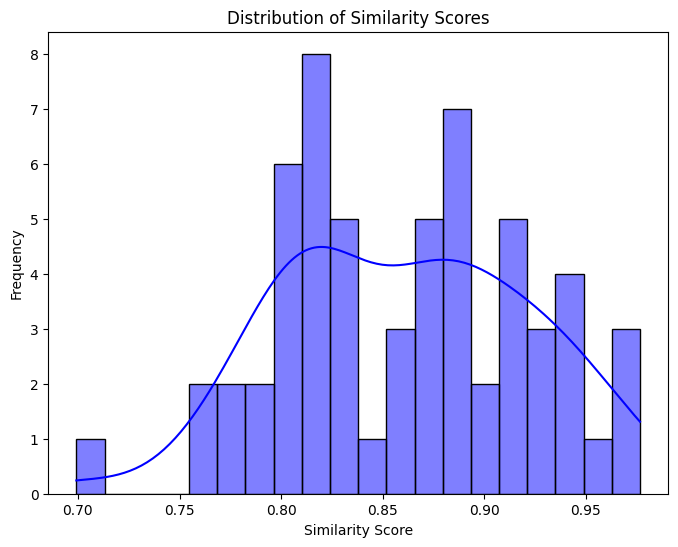

In [98]:


plt.figure(figsize=(8, 6))
sns.histplot(lookalike_df['SimilarityScore'], bins=20, kde=True, color='blue')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

<ipython-input-99-7d99920bfe84>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SimilarCustomerID', y='SimilarityScore', data=customer_recommendations, palette='viridis')


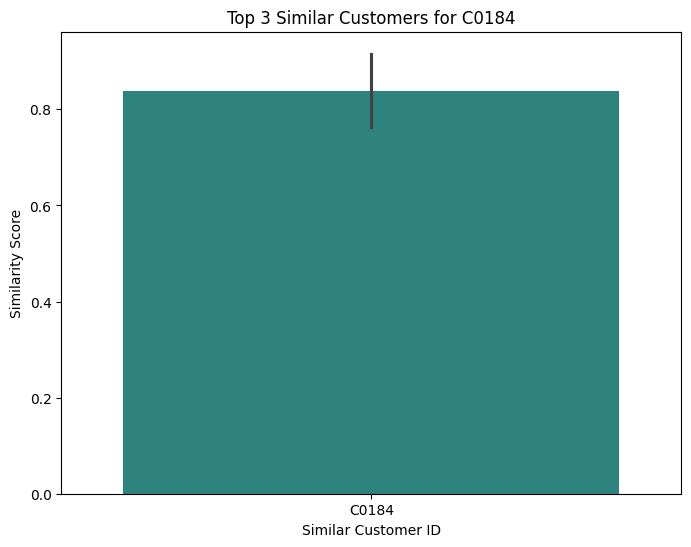

<ipython-input-99-7d99920bfe84>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SimilarCustomerID', y='SimilarityScore', data=customer_recommendations, palette='viridis')


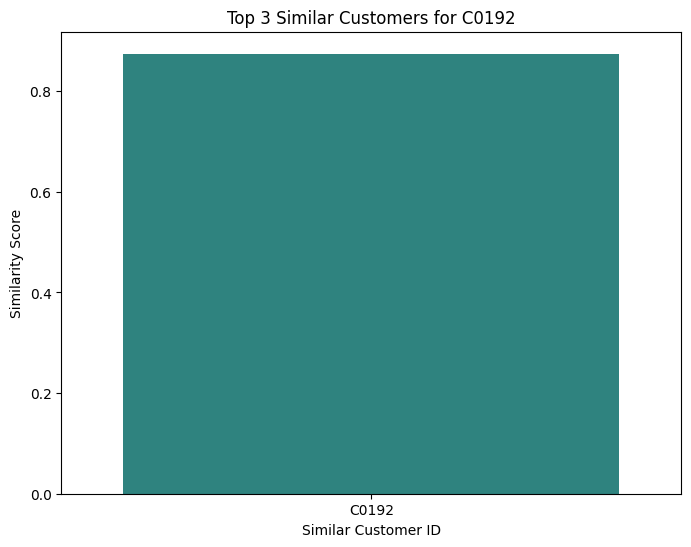

<ipython-input-99-7d99920bfe84>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SimilarCustomerID', y='SimilarityScore', data=customer_recommendations, palette='viridis')


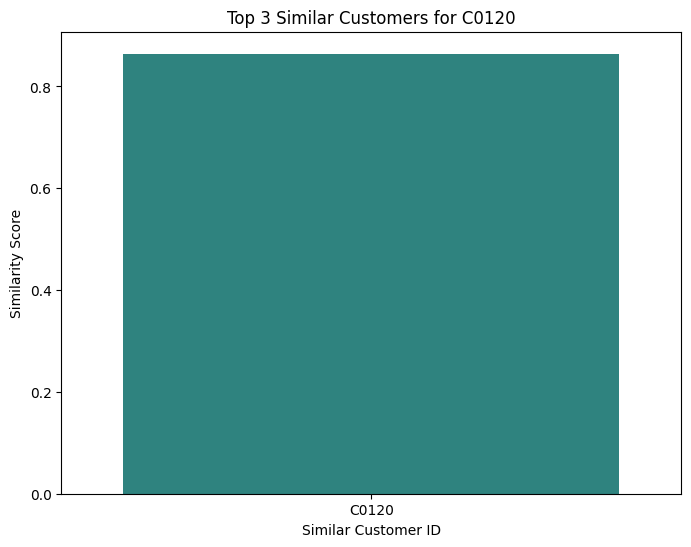

<ipython-input-99-7d99920bfe84>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SimilarCustomerID', y='SimilarityScore', data=customer_recommendations, palette='viridis')


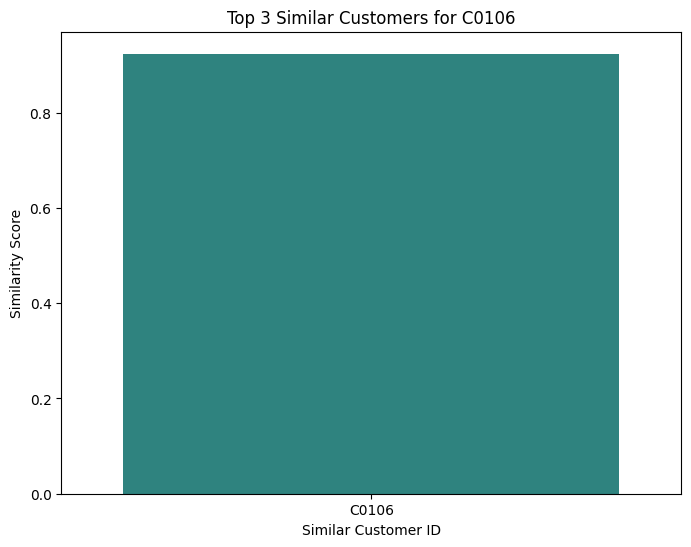

<ipython-input-99-7d99920bfe84>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SimilarCustomerID', y='SimilarityScore', data=customer_recommendations, palette='viridis')


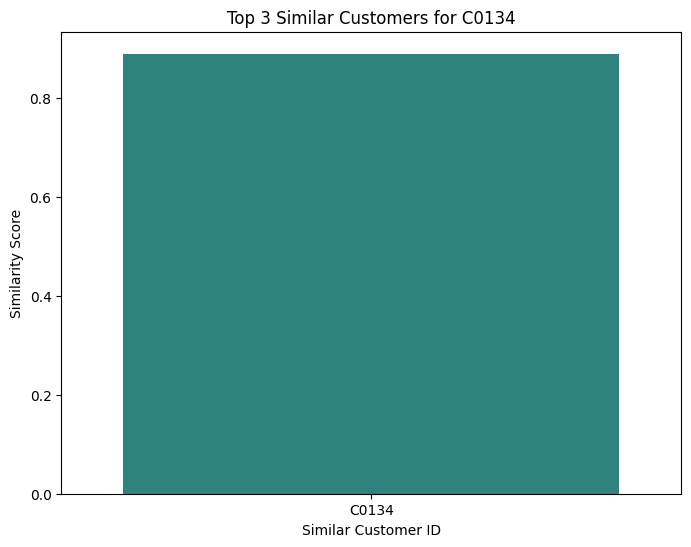

In [99]:

example_customers = lookalike_df['SimilarCustomerID'].unique()[:5]  # First 5 customers

for customer_id in example_customers:
    customer_recommendations = lookalike_df[lookalike_df['SimilarCustomerID'] == customer_id]
    plt.figure(figsize=(8, 6))
    sns.barplot(x='SimilarCustomerID', y='SimilarityScore', data=customer_recommendations, palette='viridis')
    plt.title(f'Top 3 Similar Customers for {customer_id}')
    plt.xlabel('Similar Customer ID')
    plt.ylabel('Similarity Score')
    plt.show()

In [100]:


ground_truth = {}
for customer_id in lookalike_df['SimilarCustomerID'].unique():
    customer_recommendations = lookalike_df[lookalike_df['SimilarCustomerID'] == customer_id]
    top_10_similar_customers = customer_recommendations.nlargest(10, 'SimilarityScore')['SimilarCustomerID'].tolist()
    ground_truth[customer_id] = top_10_similar_customers

In [101]:

predictions = {}
for customer_id in lookalike_df['SimilarCustomerID'].unique():
    customer_recommendations = lookalike_df[lookalike_df['SimilarCustomerID'] == customer_id]
    top_3_similar_customers = customer_recommendations.nlargest(3, 'SimilarityScore')['SimilarCustomerID'].tolist()
    predictions[customer_id] = top_3_similar_customers


In [102]:


y_true = []
y_pred = []
for customer_id in predictions:
    true_similar_customers = ground_truth[customer_id]
    predicted_similar_customers = predictions[customer_id]
    for cust in lookalike_df['SimilarCustomerID'].unique():
        if cust in true_similar_customers:
            y_true.append(1)  # correct
        else:
            y_true.append(0)  # incorrect
        if cust in predicted_similar_customers:
            y_pred.append(1)  # as similar
        else:
            y_pred.append(0)  # not  similar

In [103]:


conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# cal metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Confusion Matrix:
[[2756    0]
 [   0   53]]
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


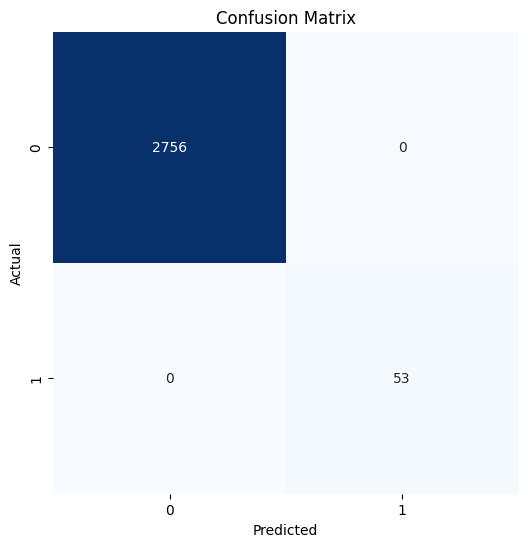

In [104]:

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()